In [1]:
#!/usr/bin/env python
# coding: utf-8
import sys
import os
import numpy as np
import pandas as pd
import argparse
import tensorflow as tf
import lightgbm as lgb
from tensorflow import keras
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam, AdamW
from keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.layers import Dense, Flatten, Reshape, Dropout, Input, Concatenate, BatchNormalization, Conv1DTranspose
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, Conv3D




2025-10-06 06:04:53.986863: I tensorflow/core/platform/cpu_feature_guard.cc:211] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from KeplerETL import _floatvector_feature, _float_feature, _int64_feature, _bytes_feature, TrainingSet, ETL, KeplerETL

from KerasModel import KerasModel, BestEpoch, PlotLoss
from KeplerModel import KeplerModel


In [3]:
IS_JUPYTER = True
TRANSFORM = 'transform'

In [4]:
if IS_JUPYTER:
  sys.argv.append('--model')
  sys.argv.append('mlp')
  sys.argv.append('--epochs')
  sys.argv.append('10')
  sys.argv.append('--batch_size')
  sys.argv.append('128')
  #sys.argv.append('--steps')
  #sys.argv.append('2940')
  sys.argv.append('--lr')
  sys.argv.append('1e-5')
  #sys.argv.append('--decay')
  #sys.argv.append('1e-6')
  #sys.argv.append('--epsilon')
  #sys.argv.append('20.0')

  sys.argv.append('--arch')
  sys.argv.append('NR')
  sys.argv.append('--monitor')
  sys.argv.append('val_loss')
  sys.argv.append('--version')
  sys.argv.append('1')
  sys.argv.append('--revision')
  sys.argv.append('1')
  sys.argv.append('--trial')
  sys.argv.append('1')
#  sys.argv.append('--transform')
#  sys.argv.append('NaN,-1,-1|Slice,0,2376|ZP,12:360,0:35:325:460:511:836:976:1121:1216:1506:1796:2086:2376')
  sys.argv.append('--datadir')
  sys.argv.append('./tfdata')
  sys.argv.append('--trainpat')
  sys.argv.append('train*.tfr')
  sys.argv.append('--validpat')
  sys.argv.append('valid*.tfr')
  sys.argv.append('--round')
  sys.argv.append('0')
  sys.argv.append('--epoch')
  sys.argv.append('0')
  #sys.argv.append('--patience')
  #sys.argv.append('5')
  #sys.argv.append('--threshold')
  #sys.argv.append('1e-6')
  sys.argv.append('--train')
  print(sys.argv)


['/usr/local/lib/python3.10/dist-packages/ipykernel_launcher.py', '-f', '/root/.local/share/jupyter/runtime/kernel-e044c4b4-c732-48d5-bb5e-28497d9f277c.json', '--model', 'mlp', '--epochs', '10', '--batch_size', '128', '--lr', '1e-5', '--arch', 'NR', '--monitor', 'val_loss', '--version', '1', '--revision', '1', '--trial', '1', '--datadir', './tfdata', '--trainpat', 'train*.tfr', '--validpat', 'valid*.tfr', '--round', '0', '--epoch', '0', '--train']


In [5]:
parser = argparse.ArgumentParser()
parser.add_argument("--model", help="model name")
parser.add_argument("--version", type=int, default=1, help="model version")
parser.add_argument("--round", type=int, default=0, help="model round")
parser.add_argument("--revision", type=int, default=0, help="model revision")
parser.add_argument("--trial", type=int, default=1, help="training trial number")
parser.add_argument("--epoch", type=int, default=0, help="model epoch")
parser.add_argument("--begin", type=int, default=0, help="start with epoch")
parser.add_argument("--patience", type=int, default=0, help="early stopping patience")
parser.add_argument("--threshold", type=float, default=1e-5, help="early stopping threshold")
parser.add_argument("--lr", type=float, default=1e-3, help="learning rate")
parser.add_argument("--epsilon", type=float, default=1.0, help="epsilon")
parser.add_argument("--epochs", type=int, default=20, help="training epochs")
parser.add_argument("--transform", default='-', help="transform")
parser.add_argument("--arch", default="NR", help="model architecture")
parser.add_argument("--ensemble1", default='-', help="1st ensemble model,arch,version")
parser.add_argument("--etransform", default='-', help="post-ensemble transform")
parser.add_argument("--ensemble2", default='-', help="2nd ensemble model,arch,version")
parser.add_argument("--batch_size", type=int, default=8192, help="batch size")
parser.add_argument("--steps", type=int, default=1000, help="total training steps")
parser.add_argument("--decay_steps", type=int, default=100, help="decay steps")
parser.add_argument("--decay", type=float, default=1e-4, help="decay rate")
parser.add_argument("--target", type=int, default=0, help="target index")
parser.add_argument('--train', action='store_true')
parser.add_argument('--tensorboard', action='store_true')
parser.add_argument('--loadtrial', action='store_true')
parser.add_argument('--trainera', action='store_true')
parser.add_argument('--datadir', default="./data", help='data directory')
parser.add_argument('--trainpat', default="train*.tfr", help='training file glob pattern')
parser.add_argument('--validpat', default="valid*.tfr", help='validation file glob pattern')
parser.add_argument('--monitor', default="val_loss", help='metric for checkpoint monitor')
parser.add_argument('--loss', default="mse", help='loss function')

if IS_JUPYTER:
  args = parser.parse_args(sys.argv[3:])
else:
  args = parser.parse_args()

print(args)


Namespace(model='mlp', version=1, round=0, revision=1, trial=1, epoch=0, begin=0, patience=0, threshold=1e-05, lr=1e-05, epsilon=1.0, epochs=10, transform='-', arch='NR', ensemble1='-', etransform='-', ensemble2='-', batch_size=128, steps=1000, decay_steps=100, decay=0.0001, target=0, train=True, tensorboard=False, loadtrial=False, trainera=False, datadir='./tfdata', trainpat='train*.tfr', validpat='valid*.tfr', monitor='val_loss', loss='mse')


In [6]:
hyperParam = {
  'batch_size': args.batch_size,
}

hyperParam['model'] = args.model
hyperParam['train'] = args.train
hyperParam['round'] = args.round
hyperParam['trial'] = args.trial
hyperParam['revision'] = args.revision
hyperParam['version'] = args.version
hyperParam['epoch'] = args.epoch
hyperParam['epochs'] = args.epochs
hyperParam['begin'] = args.begin
hyperParam['patience'] = args.patience
hyperParam['threshold'] = args.threshold
hyperParam['lr'] = args.lr
hyperParam['decay'] = args.decay
hyperParam['steps'] = args.steps
hyperParam['decay_steps'] = args.decay_steps
hyperParam['epsilon'] = args.epsilon
hyperParam['arch'] = args.arch
hyperParam['loss'] = args.loss
hyperParam['monitor'] = args.monitor
hyperParam['transform'] = []

if not args.transform == '-':
  filters = args.transform.split('|')
  for f in range(len(filters)):
    param = filters[f].split(',')
    if len(param) == 3:
      hyperParam['transform'].append({
        'name': param[0],
        'arg1': param[1],
        'arg2': param[2]
        })
    if len(param) == 4:
      hyperParam['transform'].append({
        'name': param[0],
        'arg1': param[1],
        'arg2': param[2],
        'arg3': param[3]
        })

In [7]:
print(hyperParam)

{'batch_size': 128, 'model': 'mlp', 'train': True, 'round': 0, 'trial': 1, 'revision': 1, 'version': 1, 'epoch': 0, 'epochs': 10, 'begin': 0, 'patience': 0, 'threshold': 1e-05, 'lr': 1e-05, 'decay': 0.0001, 'steps': 1000, 'decay_steps': 100, 'epsilon': 1.0, 'arch': 'NR', 'loss': 'mse', 'monitor': 'val_loss', 'transform': []}


In [8]:
# Everything that creates variables should be under the strategy scope.
# In general this is only model construction & `compile()`.
model = KeplerModel(args.model, hyperParam)

ds = model.DataSet(args.datadir, args.trainpat)
dsv = model.DataSet(args.datadir, args.validpat)


2025-10-06 06:04:57.004167: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-10-06 06:04:57.004197: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: nvgpu
2025-10-06 06:04:57.004206: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: nvgpu
2025-10-06 06:04:57.004289: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 550.163.1
2025-10-06 06:04:57.004308: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 550.163.1
2025-10-06 06:04:57.004315: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 550.163.1


In [9]:
# Train the model
if args.trial:
  model.modelTrial = args.trial
else:
  model.modelTrial = 1
model.SetLoss(hyperParam['loss'])
model.SetMonitor(hyperParam['monitor'])
model.LoadModel()
model.SetModelTrial(hyperParam['trial'])
model.SetTensorboard(args.tensorboard)
#model.modelRevision = napi.GetRound()          
#autoencoder = model.model.get_layer('input_output')
#autoencoder.trainable = False
#z = model.model.get_layer('z')
#z.trainable = False
model.model.summary()



Loading  model/mlpv1r1t1-e0
Model: "mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 256)]          0         
                                                                 
 dense (Dense)               (None, 2, 1024)           263168    
                                                                 
 batch_normalization (Batch  (None, 2, 1024)           4096      
 Normalization)                                                  
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 2, 1024)           0         
                                                                 
 dense_1 (Dense)             (None, 2, 512)            524800    
                                                                 
 batch_normalization_1 (Bat  (None, 2, 512)            2048      
 chNormalization)                  

Training
Epoch 1/10
   4650/Unknown - 69s 12ms/step - loss: 5064.7090 - mse: 5064.7090

2025-10-06 06:06:08.935724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 1: val_loss improved from inf to 5242.12695, saving model to model/mlpv1r1t1-e1


2025-10-06 06:06:10.741101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


INFO:tensorflow:Assets written to: model/mlpv1r1t1-e1/assets


INFO:tensorflow:Assets written to: model/mlpv1r1t1-e1/assets


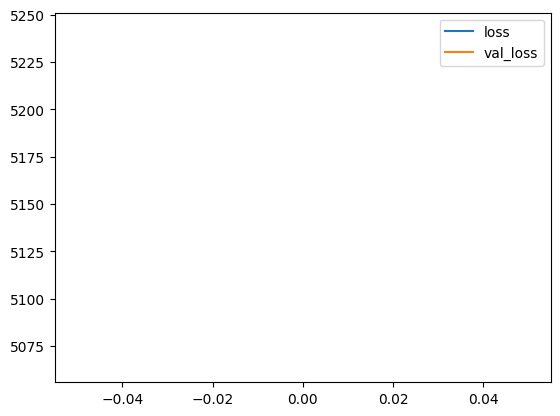

<Figure size 640x480 with 0 Axes>

{'loss': 5064.708984375, 'mse': 5064.708984375, 'val_loss': 5242.126953125, 'val_mse': 5242.126953125}
4650/4650 [==============================] - 75s 14ms/step - loss: 5064.7090 - mse: 5064.7090 - val_loss: 5242.1270 - val_mse: 5242.1270
Epoch 2/10
4648/4650 [============================>.] - ETA: 0s - loss: 4945.5854 - mse: 4945.5854
Epoch 2: val_loss improved from 5242.12695 to 5117.79785, saving model to model/mlpv1r1t1-e2
INFO:tensorflow:Assets written to: model/mlpv1r1t1-e2/assets


INFO:tensorflow:Assets written to: model/mlpv1r1t1-e2/assets


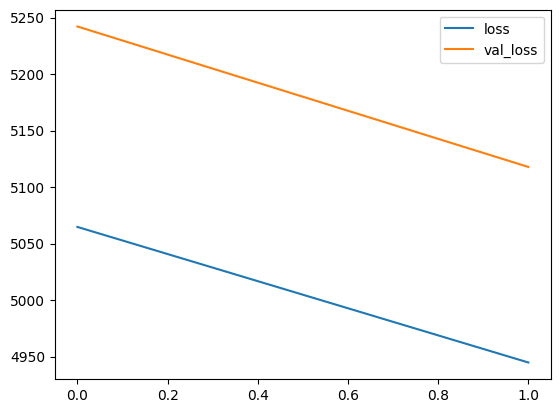

<Figure size 640x480 with 0 Axes>

{'loss': 4944.73583984375, 'mse': 4944.73583984375, 'val_loss': 5117.7978515625, 'val_mse': 5117.7978515625}
4650/4650 [==============================] - 62s 13ms/step - loss: 4944.7358 - mse: 4944.7358 - val_loss: 5117.7979 - val_mse: 5117.7979
Epoch 3/10
4650/4650 [==============================] - ETA: 0s - loss: 4832.6958 - mse: 4832.6958
Epoch 3: val_loss improved from 5117.79785 to 5018.85547, saving model to model/mlpv1r1t1-e3
INFO:tensorflow:Assets written to: model/mlpv1r1t1-e3/assets


INFO:tensorflow:Assets written to: model/mlpv1r1t1-e3/assets


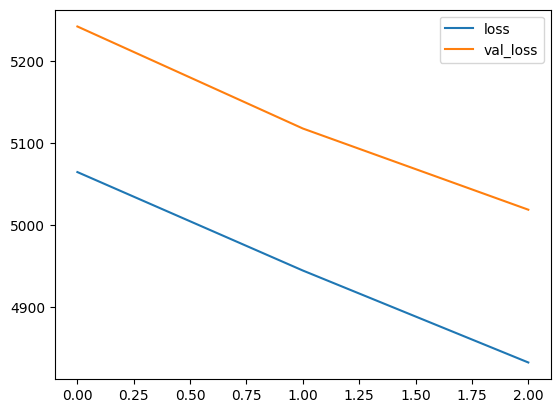

<Figure size 640x480 with 0 Axes>

{'loss': 4832.69580078125, 'mse': 4832.69580078125, 'val_loss': 5018.85546875, 'val_mse': 5018.85546875}
4650/4650 [==============================] - 62s 13ms/step - loss: 4832.6958 - mse: 4832.6958 - val_loss: 5018.8555 - val_mse: 5018.8555
Epoch 4/10
4650/4650 [==============================] - ETA: 0s - loss: 4746.8408 - mse: 4746.8408
Epoch 4: val_loss improved from 5018.85547 to 4941.09717, saving model to model/mlpv1r1t1-e4
INFO:tensorflow:Assets written to: model/mlpv1r1t1-e4/assets


INFO:tensorflow:Assets written to: model/mlpv1r1t1-e4/assets


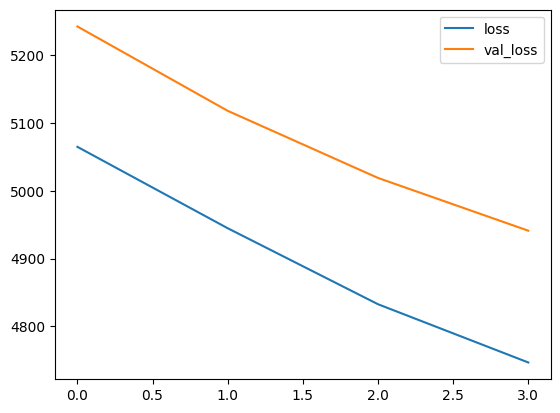

<Figure size 640x480 with 0 Axes>

{'loss': 4746.8408203125, 'mse': 4746.8408203125, 'val_loss': 4941.09716796875, 'val_mse': 4941.09716796875}
4650/4650 [==============================] - 62s 13ms/step - loss: 4746.8408 - mse: 4746.8408 - val_loss: 4941.0972 - val_mse: 4941.0972
Epoch 5/10
4649/4650 [============================>.] - ETA: 0s - loss: 4684.3105 - mse: 4684.3105
Epoch 5: val_loss improved from 4941.09717 to 4856.96875, saving model to model/mlpv1r1t1-e5
INFO:tensorflow:Assets written to: model/mlpv1r1t1-e5/assets


INFO:tensorflow:Assets written to: model/mlpv1r1t1-e5/assets


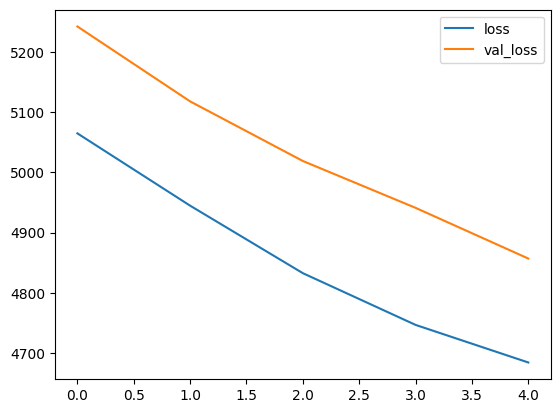

<Figure size 640x480 with 0 Axes>

{'loss': 4684.478515625, 'mse': 4684.478515625, 'val_loss': 4856.96875, 'val_mse': 4856.96875}
4650/4650 [==============================] - 62s 13ms/step - loss: 4684.4785 - mse: 4684.4785 - val_loss: 4856.9688 - val_mse: 4856.9688
Epoch 6/10
4647/4650 [============================>.] - ETA: 0s - loss: 4629.6846 - mse: 4629.6846
Epoch 6: val_loss improved from 4856.96875 to 4827.61865, saving model to model/mlpv1r1t1-e6
INFO:tensorflow:Assets written to: model/mlpv1r1t1-e6/assets


INFO:tensorflow:Assets written to: model/mlpv1r1t1-e6/assets


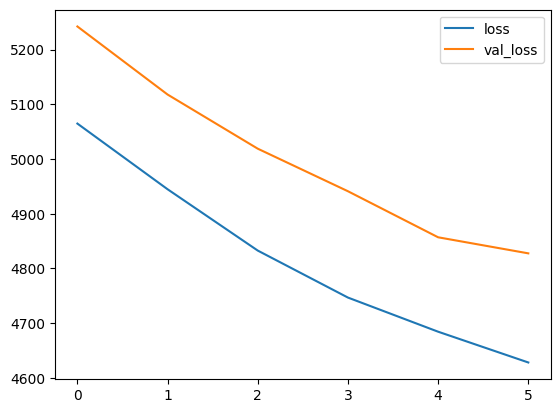

<Figure size 640x480 with 0 Axes>

{'loss': 4628.2509765625, 'mse': 4628.2509765625, 'val_loss': 4827.61865234375, 'val_mse': 4827.61865234375}
4650/4650 [==============================] - 62s 13ms/step - loss: 4628.2510 - mse: 4628.2510 - val_loss: 4827.6187 - val_mse: 4827.6187
Epoch 7/10
4647/4650 [============================>.] - ETA: 0s - loss: 4610.0435 - mse: 4610.0435
Epoch 7: val_loss improved from 4827.61865 to 4813.57129, saving model to model/mlpv1r1t1-e7
INFO:tensorflow:Assets written to: model/mlpv1r1t1-e7/assets


INFO:tensorflow:Assets written to: model/mlpv1r1t1-e7/assets


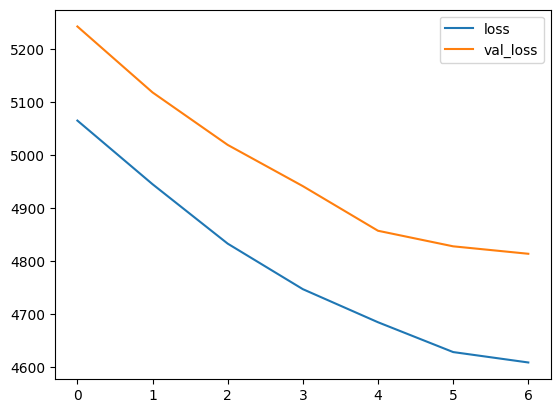

<Figure size 640x480 with 0 Axes>

{'loss': 4608.6220703125, 'mse': 4608.6220703125, 'val_loss': 4813.5712890625, 'val_mse': 4813.5712890625}
4650/4650 [==============================] - 62s 13ms/step - loss: 4608.6221 - mse: 4608.6221 - val_loss: 4813.5713 - val_mse: 4813.5713
Epoch 8/10
4650/4650 [==============================] - ETA: 0s - loss: 4601.3774 - mse: 4601.3774
Epoch 8: val_loss improved from 4813.57129 to 4808.25146, saving model to model/mlpv1r1t1-e8
INFO:tensorflow:Assets written to: model/mlpv1r1t1-e8/assets


INFO:tensorflow:Assets written to: model/mlpv1r1t1-e8/assets


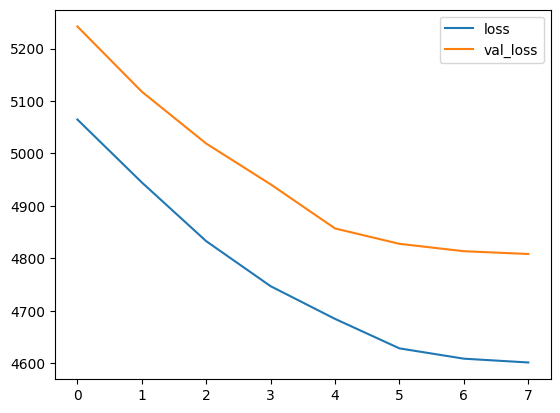

<Figure size 640x480 with 0 Axes>

{'loss': 4601.37744140625, 'mse': 4601.37744140625, 'val_loss': 4808.25146484375, 'val_mse': 4808.25146484375}
4650/4650 [==============================] - 62s 13ms/step - loss: 4601.3774 - mse: 4601.3774 - val_loss: 4808.2515 - val_mse: 4808.2515
Epoch 9/10
4649/4650 [============================>.] - ETA: 0s - loss: 4599.4326 - mse: 4599.4326
Epoch 9: val_loss improved from 4808.25146 to 4806.40381, saving model to model/mlpv1r1t1-e9
INFO:tensorflow:Assets written to: model/mlpv1r1t1-e9/assets


INFO:tensorflow:Assets written to: model/mlpv1r1t1-e9/assets


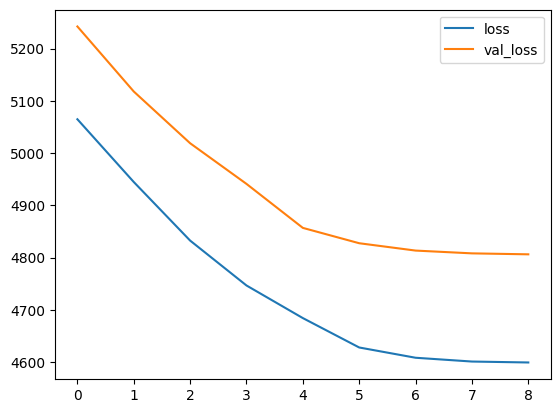

<Figure size 640x480 with 0 Axes>

{'loss': 4599.5869140625, 'mse': 4599.5869140625, 'val_loss': 4806.40380859375, 'val_mse': 4806.40380859375}
4650/4650 [==============================] - 62s 13ms/step - loss: 4599.5869 - mse: 4599.5869 - val_loss: 4806.4038 - val_mse: 4806.4038
Epoch 10/10
4646/4650 [============================>.] - ETA: 0s - loss: 4599.2539 - mse: 4599.2539
Epoch 10: val_loss improved from 4806.40381 to 4805.80322, saving model to model/mlpv1r1t1-e10
INFO:tensorflow:Assets written to: model/mlpv1r1t1-e10/assets


INFO:tensorflow:Assets written to: model/mlpv1r1t1-e10/assets


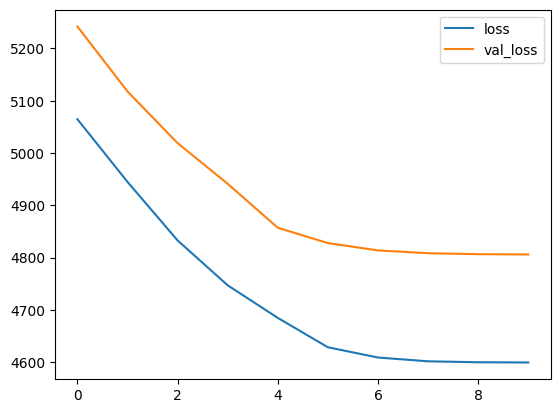

<Figure size 640x480 with 0 Axes>

{'loss': 4599.15380859375, 'mse': 4599.15380859375, 'val_loss': 4805.80322265625, 'val_mse': 4805.80322265625}
4650/4650 [==============================] - 62s 13ms/step - loss: 4599.1538 - mse: 4599.1538 - val_loss: 4805.8032 - val_mse: 4805.8032
Done


In [10]:
  print("Training")   
  model.Train(ds, dsv)
  print("Done")  


In [11]:
cmd = "ls -lt model"
os.system(cmd)

total 0
drwxr-xr-x 4 root root 106 Oct  6 06:15 mlpv1r1t1-e10
drwxr-xr-x 4 root root 106 Oct  6 06:14 mlpv1r1t1-e9
drwxr-xr-x 4 root root 106 Oct  6 06:13 mlpv1r1t1-e8
drwxr-xr-x 4 root root 106 Oct  6 06:12 mlpv1r1t1-e7
drwxr-xr-x 4 root root 106 Oct  6 06:11 mlpv1r1t1-e6
drwxr-xr-x 4 root root 106 Oct  6 06:10 mlpv1r1t1-e5
drwxr-xr-x 4 root root 106 Oct  6 06:09 mlpv1r1t1-e4
drwxr-xr-x 4 root root 106 Oct  6 06:08 mlpv1r1t1-e3
drwxr-xr-x 4 root root 106 Oct  6 06:07 mlpv1r1t1-e2
drwxr-xr-x 4 root root 106 Oct  6 06:06 mlpv1r1t1-e1
drwxr-xr-x 4 root root 106 Oct  6 03:13 mlpv1r1t1-e0


0